In [1]:
# Google Drive를 srcnn이라는 디렉토리 이름으로 Mount 시행
from google.colab import drive
drive.mount('srcnn')

Mounted at srcnn


In [2]:
# 필요한 module import하기
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py
import srcnn
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import time

# Pytorch device 정의하기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 디렉토리 이동
!cd /content

# 데이터를 저장할 폴더 생성
!mkdir data

# 압축 풀기
!unzip /content/srcnn/MyDrive/input.zip -d /content/data

Archive:  /content/srcnn/MyDrive/input.zip
   creating: /content/data/bicubic_2x/
  inflating: /content/data/bicubic_2x/baby_GT.bmp  
  inflating: /content/data/bicubic_2x/bird_GT.bmp  
  inflating: /content/data/bicubic_2x/butterfly_GT.bmp  
  inflating: /content/data/bicubic_2x/head_GT.bmp  
  inflating: /content/data/bicubic_2x/woman_GT.bmp  
   creating: /content/data/Set5/
 extracting: /content/data/Set5/baby.png  
 extracting: /content/data/Set5/bird.png  
 extracting: /content/data/Set5/butterfly.png  
 extracting: /content/data/Set5/head.png  
  inflating: /content/data/Set5/woman.png  
   creating: /content/data/T91/
  inflating: /content/data/T91/t1.png  
 extracting: /content/data/T91/t10.png  
 extracting: /content/data/T91/t11.png  
  inflating: /content/data/T91/t12.png  
 extracting: /content/data/T91/t13.png  
 extracting: /content/data/T91/t14.png  
  inflating: /content/data/T91/t15.png  
 extracting: /content/data/T91/t16.png  
 extracting: /content/data/T91/t17.png 

In [4]:
# 입력 이미지의 차원 설정하기
input_h, input_w = 33, 33
out_h, out_w = 33,33

# Python에서 HDF5 바이너리 데이터 포맷을 사용하기 위한 사용법은 다음과 같다.
file = h5py.File("/content/data/train_mscale.h5")
in_train = file['data'][:] # 입력 이미지
out_train = file['label'][:] # 출력 이미지
file.close() # File Stream 닫기

# in_train, out_train은 (21824, 1, 33, 33)의 차원을 가진다
# 이 값들을 연산의 편의를 위하여 float32 Type으로 변환한다
in_train = in_train.astype('float32')
out_train = out_train.astype('float32')

# train Dataset : validation Dataset = 0.75 : 0.25 비율로 분할한다
(x_train, x_val, y_train, y_val) = train_test_split(in_train, out_train, test_size=0.25 )
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(16368, 1, 33, 33)
(5456, 1, 33, 33)
(16368, 1, 33, 33)
(5456, 1, 33, 33)


In [5]:
# Custom Dataset 생성하기
# Return되는 image는 Low-Resolution Image, label은 High-Resolution Image이다
class SRCNNDataset(Dataset):
  def __init__(self, image_data, labels):
    self.image_data = image_data
    self.labels = labels

  def __len__(self):
    return len(self.image_data)

  def __getitem__(self, index):
    image = self.image_data[index]
    label = self.labels[index]
    return (torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.float))

In [6]:
# Dataset과 DataLoader를 정의한다
train_ds = SRCNNDataset(x_train, y_train)
val_ds = SRCNNDataset(x_val, y_val)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

torch.Size([64, 1, 33, 33]) torch.Size([64, 1, 33, 33])


Text(0.5, 1.0, 'target')

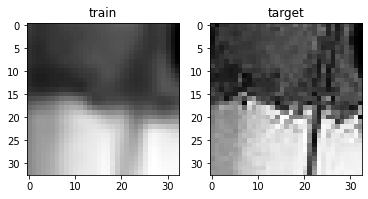

In [7]:
# DataLoader의 출력을 Test하고 시각화 하기
for x,y in train_dl:
  print(x.shape, y.shape)
  break

img = x[0]
target = y[0]

from torchvision.transforms.functional import to_pil_image

plt.figure()
plt.subplot(1,2,1)
plt.imshow(to_pil_image(img), cmap="gray")
plt.title("train")
plt.subplot(1,2,2)
plt.imshow(to_pil_image(target), cmap="gray")
plt.title("target")

In [8]:
# 본격적으로 SRCNN 구현하기
class SRCNN(nn.Module):
  def __init__(self):
    super().__init__()

    # padding_mode="replicate"는 zero_pad가 아닌 주변 값을 복사하여 pad를 추가하는 방식이다
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, stride=1, padding=2, padding_mode="replicate")
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, stride=1, padding=2, padding_mode="replicate")
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, stride=1, padding=2, padding_mode="replicate")

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.conv3(x)

    return x  

In [9]:
# 가중치 초기화 함수 정의
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

model = SRCNN().to(device)
# 가중치 초기화 함수 적용하기
model.apply(initialize_weights)

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)

In [10]:
# 손실함수 : MSE Loss
loss_func = nn.MSELoss()

# optimizer 정의
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

In [11]:
# 모델의 평가지표 : PSNR (Peak Signal-to-Noise Ratio)
# 모델의 출력값과 high-resolution의 유사도를 측정한다
# PSNR값이 크면 클 수록 좋은 것이다
def psnr(label, outputs, max_val = 1):
  label = label.cpu().detach().numpy()
  outputs = outputs.cpu().detach().numpy()
  img_diff = outputs - label
  rmse = math.sqrt(np.mean(img_diff)**2)
  
  # label과 output이 완전히 일치하는 경우
  if rmse == 0:
    return 100
  else:
    psnr = 20 * math.log10(max_val/rmse)
    return psnr

In [12]:
# 학습을 위한 함수 정의하기
def train(model, data_dl):
  model.train()
  running_loss = 0.0
  running_psnr = 0.0

  for ba, data in enumerate(data_dl):
    image = data[0].to(device) # Low-Resolution Image
    label = data[1].to(device) # High-Resolution Image

    optimizer.zero_grad()
    outputs = model(image)
    loss = loss_func(outputs, label)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() # 하나의 batch동안의 total loss
    batch_psnr = psnr(label, outputs)
    running_psnr += batch_psnr
  
  final_loss = running_loss / len(data_dl.dataset) # 전체 데이터 개수로 나누어준다
  final_psnr = running_psnr / int(len(train_ds)/data_dl.batch_size) # batch개수로 나누어준다
  return final_loss, final_psnr

In [13]:
# validation용 함수를 정의한다
# 매 epoch마다 모델이 출력한 high-resolution image를 저장할 수 있도록 하였다
def validate(model, data_dl, epoch):
    # epoch는 이미지를 저장할때, 이미지의 이름으로 사용
    
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for ba, data in enumerate(data_dl):
            image = data[0].to(device)
            label = data[1].to(device)

            outputs = model(image)
            loss = loss_func(outputs, label)

            running_loss += loss.item()
            batch_psnr = psnr(label,outputs)
            running_psnr += batch_psnr

        outputs = outputs.cpu()
        # tensor를 입력받아 이미지 파일로 저장합니다.
        save_image(outputs, f'/content/outputs/{epoch}.png')
    
    final_loss = running_loss / len(data_dl.dataset)
    final_psnr = running_psnr / int(len(val_ds)/data_dl.batch_size)
    return final_loss, final_psnr

In [14]:
# 이미지를 저장할 폴더 생성
!mkdir outputs

In [15]:
# 학습 진행하기. 100Epoch학습
num_epochs = 100

train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(num_epochs):
  print(f'Epoch {epoch + 1} of {num_epochs}')
  train_epoch_loss, train_epoch_psnr = train(model, train_dl)
  val_epoch_loss, val_epoch_psnr = validate(model, val_dl, epoch)

  train_loss.append(train_epoch_loss)
  train_psnr.append(train_epoch_psnr)
  val_loss.append(val_epoch_loss)
  val_psnr.append(val_epoch_psnr)
  end = time.time()
  print(f'Train PSNR: {train_epoch_psnr:.3f}, Val PSNR: {val_epoch_psnr:.3f}, Time: {end-start:.2f} sec')

Epoch 1 of 100
Train PSNR: 46.429, Val PSNR: 64.509, Time: 8.65 sec
Epoch 2 of 100
Train PSNR: 61.570, Val PSNR: 58.921, Time: 10.96 sec
Epoch 3 of 100
Train PSNR: 58.671, Val PSNR: 73.945, Time: 13.28 sec
Epoch 4 of 100
Train PSNR: 59.259, Val PSNR: 62.767, Time: 15.58 sec
Epoch 5 of 100
Train PSNR: 62.517, Val PSNR: 59.973, Time: 17.89 sec
Epoch 6 of 100
Train PSNR: 62.657, Val PSNR: 53.257, Time: 20.19 sec
Epoch 7 of 100
Train PSNR: 59.960, Val PSNR: 58.823, Time: 22.51 sec
Epoch 8 of 100
Train PSNR: 59.224, Val PSNR: 64.254, Time: 24.82 sec
Epoch 9 of 100
Train PSNR: 59.668, Val PSNR: 72.953, Time: 27.13 sec
Epoch 10 of 100
Train PSNR: 56.445, Val PSNR: 53.530, Time: 29.44 sec
Epoch 11 of 100
Train PSNR: 58.926, Val PSNR: 46.217, Time: 32.17 sec
Epoch 12 of 100
Train PSNR: 56.159, Val PSNR: 72.285, Time: 34.66 sec
Epoch 13 of 100
Train PSNR: 54.006, Val PSNR: 62.225, Time: 36.97 sec
Epoch 14 of 100
Train PSNR: 54.464, Val PSNR: 56.472, Time: 39.28 sec
Epoch 15 of 100
Train PSNR: 54

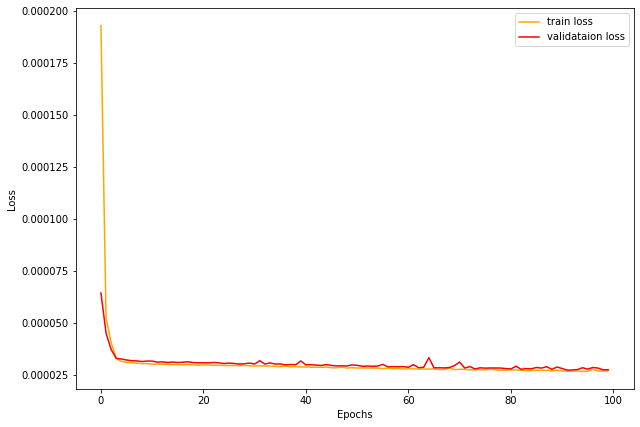

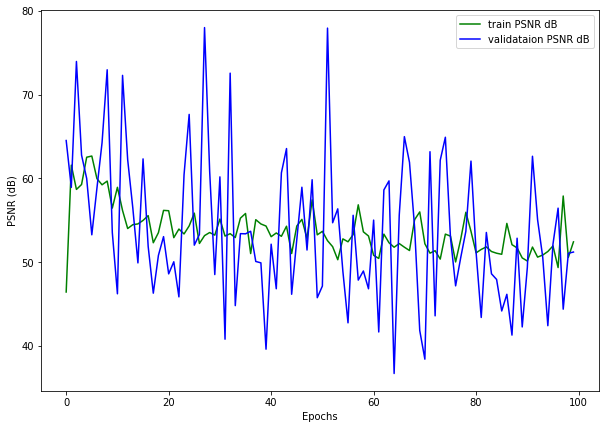

In [16]:
# Train_loss, Validation Loss 시각화하기
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Train_PSNR, Validation_PSNR 시각화하기
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.show()

Text(0.5, 1.0, 'ground_truth')

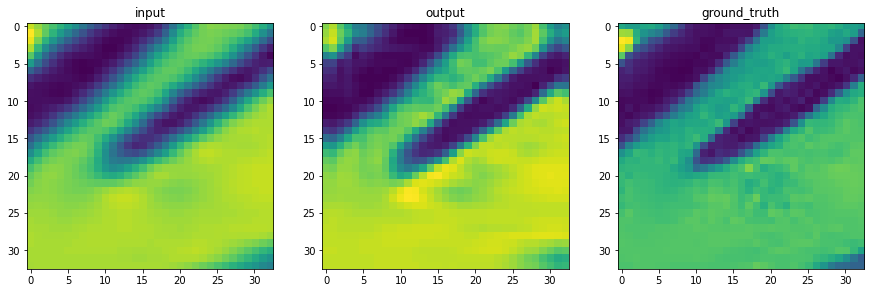

In [18]:
# SRCNN의 해상도 복원 성능 확인해보기
for img, label in val_dl:
  img = img[0] # 첫 batch의 첫 번째 이미지
  label = label[0]
  break

# Super - Resolution
model.eval()
with torch.no_grad():
  img_ = img.unsqueeze(0) # batch 차원을 만들어준다
  img_ = img_.to(device) # GPU에 load
  output = model(img_) # 모델에 저해상도 이미지를 입력해 고해상도 이미지 출력
  output = output.squeeze(0) # 다시 일반 이미지 차원 (3차원)으로 만들기

plt.figure(figsize=(15,15))

# 입력된 저해상도 이미지 출력
plt.subplot(1,3,1)
plt.imshow(to_pil_image(img))
plt.title("input")

# 모델이 출력한 고해상도 이미지 출력
plt.subplot(1,3,2)
plt.imshow(to_pil_image(output))
plt.title("output")

# 원본 고해상도 이미지 출력
plt.subplot(1,3,3)
plt.imshow(to_pil_image(label))
plt.title("ground_truth")